Cross-group edge ratio increases with fixed number of edges

Trial 1 of 2
    Within-group edge ratio 0.875
        Van.   | DP: 0.028, Err.: 0.051, F1: 0.261
        DP     | DP: 0.014, Err.: 0.238, F1: 0.261
        Nw. DP | DP: 0.014, Err.: 0.238, F1: 0.261
    Within-group edge ratio 0.750
        Van.   | DP: 0.017, Err.: 0.044, F1: 0.261
        DP     | DP: 0.008, Err.: 0.169, F1: 0.261
        Nw. DP | DP: 0.008, Err.: 0.169, F1: 0.261
    Within-group edge ratio 0.625
        Van.   | DP: 0.010, Err.: 0.056, F1: 0.261
        DP     | DP: 0.003, Err.: 0.165, F1: 0.261
        Nw. DP | DP: 0.003, Err.: 0.165, F1: 0.261
    Within-group edge ratio 0.500
        Van.   | DP: 0.001, Err.: 0.054, F1: 0.261
        DP     | DP: 0.002, Err.: 0.108, F1: 0.261
        Nw. DP | DP: 0.002, Err.: 0.108, F1: 0.261
    Within-group edge ratio 0.375
        Van.   | DP: 0.005, Err.: 0.058, F1: 0.261
        DP     | DP: 0.008, Err.: 0.091, F1: 0.261
        Nw. DP | DP: 0.008, Err.: 0.091, F

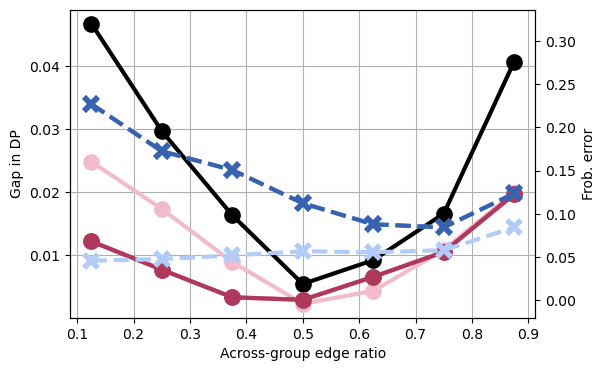

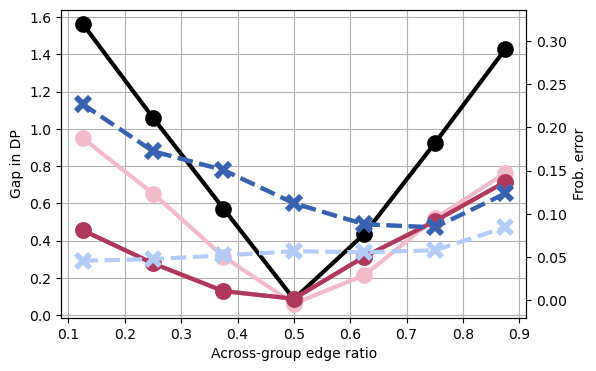

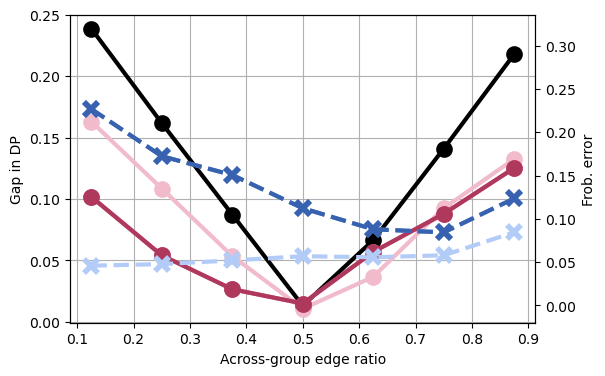

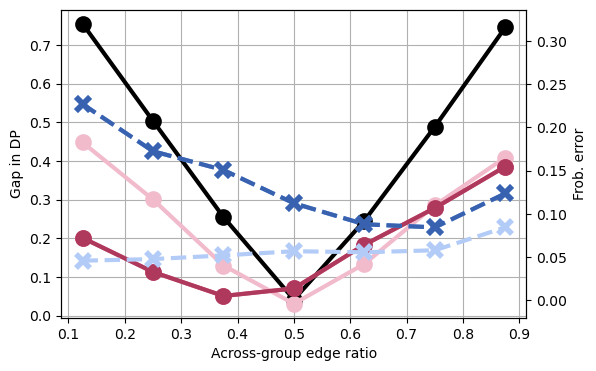

In [36]:
# Topology inference as cross-group edge ratio increases with fixed number of edges
from exp_class import *
import networkx as nx
import pandas as pd
# --------------------------------

# --------------------------------
print('Cross-group edge ratio increases with fixed number of edges')
# --------------------------------


# --------------------------------
config_name = 'config/edgeratio.jsonc'
exp_params = load_params(config_name)
G = exp_params['G']
N = exp_params['N']
N = N + N%2
num_trials = exp_params['num_trials']
num_trials = 1
params = {key:exp_params[key] for key in ['beta','lamb','eta','verbose']}
# --------------------------------


# --------------------------------
# Experiment settings
verbose = True
num_range = 1 #7

inratio_range = np.linspace(0,1,num_range+2)[1:-1]
# --------------------------------


# --------------------------------
# Results
results_bias = {key1:{key2:np.zeros((num_trials,num_range))
                for key2 in ['true','nti','dp','nodewise']} 
                for key1 in ['dp','dp_scaled','dp_unweighted','ratio']}
results_frob = {key2:np.zeros((num_trials,num_range))
                for key2 in ['nti','dp','nodewise']}
results_f1 = {key2:np.zeros((num_trials,num_range))
              for key2 in ['nti','dp','nodewise']}
# --------------------------------


# --------------------------------
m_name = { 'nti':'Van.  ', 'dp':'DP    ', 'nodewise':'Nw. DP' }
tab = '    '
seed = 1111
np.random.seed(seed)
for t in range(num_trials):
    if verbose:
        print('')
        print(f'Trial {t+1} of {num_trials}')

    # --------------------------------
    # Group assignment
    z = np.ones(N,dtype=int)
    z[:int(N/2)] = 0
    Z = np.eye(G)[z].T
    # --------------------------------


    # --------------------------------
    # Create base graph
    within_inds = np.where(np.sum([mat2lowtri((z[:,None]==g)*(z[None]==g)) for g in range(G)],axis=0)==1)[0]
    across_inds = np.where(np.sum([mat2lowtri((z[:,None]==g1)*(z[None]==g2)) for g1 in range(G) for g2 in np.delete(np.arange(G),g1)],axis=0)==1)[0]
    a0 = np.zeros(kchoose2(N))
    a0[within_inds] = np.random.binomial(1,exp_params['edge_prob'],len(within_inds))
    A0 = lowtri2mat(a0)
    L = np.diag(np.sum(A0,axis=0)) - A0
    while np.sum( np.linalg.eigh(L)[0]<1e-9 ) > 2:
        a0 = np.zeros(kchoose2(N))
        a0[within_inds] = np.random.binomial(1,exp_params['edge_prob'],len(within_inds))
        A0 = lowtri2mat(a0)
        L = np.diag(np.sum(A0,axis=0)) - A0
    # --------------------------------


    # --------------------------------
    for i,in_ratio in enumerate(inratio_range):
        if verbose:
            print(f'{tab}Within-group edge ratio {1-in_ratio:.3f}')

        # --------------------------------
        # Rewire within-group edges to across-group edges
        modify_graph = True
        while modify_graph:
            a = a0.copy()
            rewire_out = int(np.sum(a0!=0)*in_ratio)
            edge_del = np.random.choice(np.where(a0!=0)[0],rewire_out,replace=False)
            edge_add = np.random.choice(across_inds,rewire_out,replace=False)
            a[edge_del] = 0
            a[edge_add] = 1
            A = lowtri2mat(a)
            L = np.diag( np.sum(A,axis=0) ) - A
            modify_graph = np.sum( np.linalg.eigh(L)[0]<1e-9 ) <= 1

        exp = NTIExperiment(A,Z)
        # C = create_poly_cov(A=exp.A,L=exp_params['L'])
        # exp.set_C(C)
        exp.generate_C(M=exp_params['M'],L=exp_params['L'],signal_model=exp_params['signal_model'])
        # --------------------------------


        # --------------------------------
        # Estimate graphs and compute error and bias

        # True bias
        key_m = 'true'
        for key_b in ['dp','dp_scaled','dp_unweighted','ratio']:
            results_bias[key_b][key_m][t,i] = exp.compute_true_bias(bias_type=key_b)
        
        # Estimated bias and error
        for key_m in ['nti','dp','nodewise']:
            params['bias_type'] = key_m
            exp.est_A(params,BIAS_PENALTY=params['bias_type']!='nti')
            
            for key_b in ['dp','dp_scaled','dp_unweighted','ratio']:
                results_bias[key_b][key_m][t,i] = exp.compute_est_bias(bias_type=key_b)
            results_frob[key_m][t,i] = exp.compute_frob_error()
            results_f1[key_m][t,i] = exp.compute_f1_score()
            if verbose:
                print(f"{tab*2}{m_name[key_m]} | DP: {results_bias['dp'][key_m][t,i]:.3f}, Err.: {results_frob[key_m][t,i]:.3f}, F1: {results_f1[key_m][t,i]:.3f}")
        # --------------------------------
    # --------------------------------
# --------------------------------


# --------------------------------
bias_mean = {key_b: {key_m: np.mean(results_bias[key_b][key_m],axis=0)
             for key_m in ['true','nti','dp','nodewise']}
             for key_b in ['dp','dp_scaled','dp_unweighted','ratio']}
frob_mean = {key_m: np.mean(results_frob[key_m],axis=0)
             for key_m in ['nti','dp','nodewise']}
f1_mean = {key_m: np.mean(results_f1[key_m],axis=0)
           for key_m in ['nti','dp','nodewise']}
# --------------------------------


# --------------------------------
for key_b in ['dp','dp_scaled','dp_unweighted','ratio']:
    # --------------------------------
    fig = plt.figure(figsize=(6,4))
    ax1 = fig.subplots()
    ax1.grid(True)
    ax1.set_xlabel('Across-group edge ratio')
    ax2 = ax1.twinx()
    ax1.set_ylabel('Gap in DP')
    ax2.set_ylabel('Frob. error')
    # --------------------------------


    # --------------------------------
    plt_args = {}
    plt_args['marker'] = 'o'
    plt_args['markeredgewidth'] = 2
    plt_args['linestyle'] = '-'
    plt_args['markersize'] = 10
    plt_args['linewidth'] = 3
    # --------------------------------


    # --------------------------------
    for key_m,c_m in dict(zip(['true','nti','dp','nodewise'],['k',reds[2],reds[8],reds[14]])).items():
        ax1.plot(inratio_range, bias_mean[key_b][key_m], **plt_args, c=c_m)
    # --------------------------------
    

    # --------------------------------
    plt_args['marker'] = 'x'
    plt_args['markeredgewidth'] = 4
    plt_args['linestyle'] = '--'
    # --------------------------------


    # --------------------------------
    for key_m,c_m in dict(zip(['nti','dp','nodewise'],[blues[2],blues[8],blues[14]])).items():
        ax2.plot(inratio_range, frob_mean[key_m], **plt_args, c=c_m)
    # --------------------------------


    # --------------------------------
    my_ylim = list(ax2.get_ylim())
    my_ylim = np.maximum((my_ylim[0]-.1),-.02),np.minimum((my_ylim[1]+.1),1.02)
    ax2.set_ylim(my_ylim)
    # --------------------------------
# --------------------------------


# --------------------------------
path = os.getcwd()
for key_b in ['dp','dp_scaled','dp_unweighted','ratio']:
    results_dict = dict(zip(['Edge_Ratio',
                            'Bias_True','Bias_NTI','Bias_DP','Bias_NW',
                            'Frob_NTI','Frob_DP','Frob_NW'],
                            [inratio_range,
                            bias_mean[key_b]['true'], bias_mean[key_b]['nti'], bias_mean[key_b]['dp'], bias_mean[key_b]['nodewise'],
                            frob_mean['nti'], frob_mean['dp'], frob_mean['nodewise'] ]))
    pd.DataFrame(results_dict).to_csv(path + f'/edgeratio_{key_b}.csv', index=False)
# --------------------------------

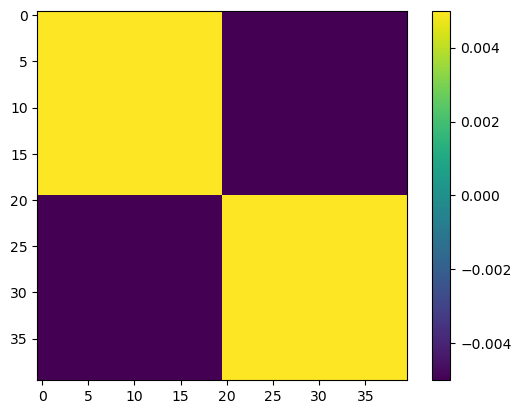

In [37]:
G,N = Z.shape
B = np.zeros((G,N))
Theta = np.eye(N)
for g in range(G):
    v1 = Z[g,:]==1
    v2 = Z[g,:]==0
    Ng = np.sum(v1)
    Nh = np.sum(v2)
    B[g,v1] = (G-1)/Ng
    B[g,v2] = -1/Nh
Bias = (B.T@B)@Theta
plt.imshow(Bias)
plt.colorbar()

152000
6.578947368421053e-06
8000.0
0.052631578947368425


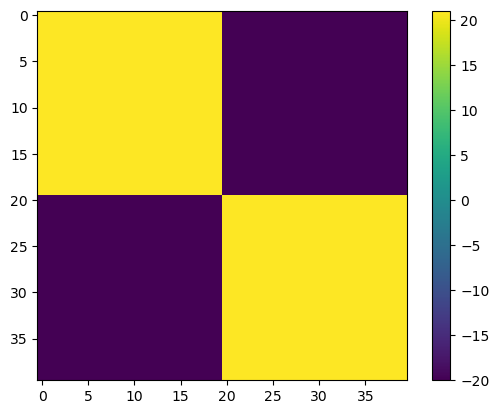

In [43]:
G,N = Z.shape
B = np.zeros((N,N))
Theta = np.eye(N)
for g in range(G):
    for h in range(G):
        if h != g:
            zg = Z[g,:]==1
            zh = Z[h,:]==1
            Ng = np.sum(zg)
            Nh = np.sum(zh)
            cg = Ng**2-Ng
            cgh = Ng*Nh
            Cgh = cgh*np.outer(zg,zg.T) - cg*np.outer(zh,zg.T)
            B += 1/(cg*cgh)*np.trace(Theta@Cgh)*Cgh.T
plt.imshow(B)
plt.colorbar()

print(cg*cgh)
print(1/(cg*cgh))
print(np.trace(Theta@Cgh))
print(1/(cg*cgh)*np.trace(Theta@Cgh))

Fair 2-SBM and biased 2-SBM as fairness penalty grows

Trial 1 of 30
Beta: 1.0000e-03
    SBM - unfair
        Van.   | DP: 0.013, Err.: 0.052, F1: 0.241
        DP     | DP: 0.013, Err.: 0.052, F1: 0.241
        Nw. DP | DP: 0.013, Err.: 0.052, F1: 0.241
    SBM - fair
        Van.   | DP: 0.001, Err.: 0.052, F1: 0.241
        DP     | DP: 0.001, Err.: 0.052, F1: 0.241
        Nw. DP | DP: 0.001, Err.: 0.052, F1: 0.241
Beta: 3.5938e-03
    SBM - unfair
        Van.   | DP: 0.013, Err.: 0.052, F1: 0.241
        DP     | DP: 0.013, Err.: 0.052, F1: 0.241
        Nw. DP | DP: 0.013, Err.: 0.052, F1: 0.241
    SBM - fair
        Van.   | DP: 0.001, Err.: 0.052, F1: 0.241
        DP     | DP: 0.001, Err.: 0.052, F1: 0.241
        Nw. DP | DP: 0.001, Err.: 0.052, F1: 0.241
Beta: 1.2915e-02
    SBM - unfair
        Van.   | DP: 0.013, Err.: 0.052, F1: 0.241
        DP     | DP: 0.013, Err.: 0.053, F1: 0.241
        Nw. DP | DP: 0.013, Err.: 0.053, F1: 0.241
    SBM - fair
        Van.   | DP

        Nw. DP | DP: 0.001, Err.: 0.057, F1: 0.211
Beta: 4.6416e-02
    SBM - unfair
        Van.   | DP: 0.012, Err.: 0.057, F1: 0.211
        DP     | DP: 0.012, Err.: 0.064, F1: 0.211
        Nw. DP | DP: 0.012, Err.: 0.064, F1: 0.211
    SBM - fair
        Van.   | DP: 0.001, Err.: 0.057, F1: 0.211
        DP     | DP: 0.001, Err.: 0.058, F1: 0.211
        Nw. DP | DP: 0.001, Err.: 0.058, F1: 0.211
Beta: 1.6681e-01
    SBM - unfair
        Van.   | DP: 0.012, Err.: 0.057, F1: 0.211
        DP     | DP: 0.011, Err.: 0.079, F1: 0.211
        Nw. DP | DP: 0.011, Err.: 0.079, F1: 0.211
    SBM - fair
        Van.   | DP: 0.001, Err.: 0.057, F1: 0.211
        DP     | DP: 0.001, Err.: 0.062, F1: 0.211
        Nw. DP | DP: 0.001, Err.: 0.062, F1: 0.211
Beta: 5.9948e-01
    SBM - unfair
        Van.   | DP: 0.012, Err.: 0.057, F1: 0.211
        DP     | DP: 0.009, Err.: 0.104, F1: 0.211
        Nw. DP | DP: 0.009, Err.: 0.104, F1: 0.211
    SBM - fair
        Van.   | DP: 0.001, Err.: 0.0

        Nw. DP | DP: 0.002, Err.: 0.061, F1: 0.233
Beta: 2.1544e+00
    SBM - unfair
        Van.   | DP: 0.016, Err.: 0.046, F1: 0.233
        DP     | DP: 0.011, Err.: 0.134, F1: 0.233
        Nw. DP | DP: 0.011, Err.: 0.134, F1: 0.233
    SBM - fair
        Van.   | DP: 0.000, Err.: 0.046, F1: 0.233
        DP     | DP: 0.002, Err.: 0.075, F1: 0.233
        Nw. DP | DP: 0.002, Err.: 0.075, F1: 0.233
Beta: 7.7426e+00
    SBM - unfair
        Van.   | DP: 0.016, Err.: 0.046, F1: 0.233
        DP     | DP: 0.010, Err.: 0.152, F1: 0.233
        Nw. DP | DP: 0.010, Err.: 0.152, F1: 0.233
    SBM - fair
        Van.   | DP: 0.000, Err.: 0.046, F1: 0.233
        DP     | DP: 0.002, Err.: 0.087, F1: 0.233
        Nw. DP | DP: 0.002, Err.: 0.087, F1: 0.233
Beta: 2.7826e+01
    SBM - unfair
        Van.   | DP: 0.016, Err.: 0.046, F1: 0.233
        DP     | DP: 0.009, Err.: 0.163, F1: 0.233
        Nw. DP | DP: 0.009, Err.: 0.163, F1: 0.233
    SBM - fair
        Van.   | DP: 0.000, Err.: 0.0

        Nw. DP | DP: 0.004, Err.: 0.107, F1: 0.247
Beta: 1.0000e+02
    SBM - unfair
        Van.   | DP: 0.028, Err.: 0.059, F1: 0.247
        DP     | DP: 0.008, Err.: 0.241, F1: 0.247
        Nw. DP | DP: 0.008, Err.: 0.241, F1: 0.247
    SBM - fair
        Van.   | DP: 0.003, Err.: 0.059, F1: 0.247
        DP     | DP: 0.004, Err.: 0.110, F1: 0.247
        Nw. DP | DP: 0.004, Err.: 0.110, F1: 0.247

Trial 8 of 30
Beta: 1.0000e-03
    SBM - unfair
        Van.   | DP: 0.022, Err.: 0.056, F1: 0.257
        DP     | DP: 0.021, Err.: 0.056, F1: 0.257
        Nw. DP | DP: 0.021, Err.: 0.056, F1: 0.257
    SBM - fair
        Van.   | DP: 0.004, Err.: 0.056, F1: 0.257
        DP     | DP: 0.004, Err.: 0.056, F1: 0.257
        Nw. DP | DP: 0.004, Err.: 0.056, F1: 0.257
Beta: 3.5938e-03
    SBM - unfair
        Van.   | DP: 0.022, Err.: 0.056, F1: 0.257
        DP     | DP: 0.021, Err.: 0.056, F1: 0.257
        Nw. DP | DP: 0.021, Err.: 0.056, F1: 0.257
    SBM - fair
        Van.   | DP: 0

        Nw. DP | DP: 0.001, Err.: 0.053, F1: 0.249
Beta: 1.2915e-02
    SBM - unfair
        Van.   | DP: 0.019, Err.: 0.053, F1: 0.249
        DP     | DP: 0.018, Err.: 0.055, F1: 0.249
        Nw. DP | DP: 0.018, Err.: 0.055, F1: 0.249
    SBM - fair
        Van.   | DP: 0.002, Err.: 0.053, F1: 0.249
        DP     | DP: 0.001, Err.: 0.053, F1: 0.249
        Nw. DP | DP: 0.001, Err.: 0.053, F1: 0.249
Beta: 4.6416e-02
    SBM - unfair
        Van.   | DP: 0.019, Err.: 0.053, F1: 0.249
        DP     | DP: 0.017, Err.: 0.063, F1: 0.249
        Nw. DP | DP: 0.017, Err.: 0.063, F1: 0.249
    SBM - fair
        Van.   | DP: 0.002, Err.: 0.053, F1: 0.249
        DP     | DP: 0.001, Err.: 0.054, F1: 0.249
        Nw. DP | DP: 0.001, Err.: 0.054, F1: 0.249
Beta: 1.6681e-01
    SBM - unfair
        Van.   | DP: 0.019, Err.: 0.053, F1: 0.249
        DP     | DP: 0.014, Err.: 0.087, F1: 0.249
        Nw. DP | DP: 0.014, Err.: 0.087, F1: 0.249
    SBM - fair
        Van.   | DP: 0.002, Err.: 0.0

        Nw. DP | DP: 0.004, Err.: 0.047, F1: 0.235
Beta: 5.9948e-01
    SBM - unfair
        Van.   | DP: 0.002, Err.: 0.714, F1: 0.235
        DP     | DP: 0.006, Err.: 0.730, F1: 0.235
        Nw. DP | DP: 0.006, Err.: 0.730, F1: 0.235
    SBM - fair
        Van.   | DP: 0.003, Err.: 0.714, F1: 0.235
        DP     | DP: 0.005, Err.: 0.674, F1: 0.235
        Nw. DP | DP: 0.005, Err.: 0.674, F1: 0.235
Beta: 2.1544e+00
    SBM - unfair
        Van.   | DP: 0.002, Err.: 0.714, F1: 0.235
        DP     | DP: 0.007, Err.: 0.121, F1: 0.235
        Nw. DP | DP: 0.007, Err.: 0.121, F1: 0.235
    SBM - fair
        Van.   | DP: 0.003, Err.: 0.714, F1: 0.235
        DP     | DP: 0.011, Err.: 0.726, F1: 0.235
        Nw. DP | DP: 0.011, Err.: 0.726, F1: 0.235
Beta: 7.7426e+00
    SBM - unfair
        Van.   | DP: 0.002, Err.: 0.714, F1: 0.235
        DP     | DP: 0.005, Err.: 0.714, F1: 0.235
        Nw. DP | DP: 0.005, Err.: 0.714, F1: 0.235
    SBM - fair
        Van.   | DP: 0.003, Err.: 0.7

        Nw. DP | DP: 0.007, Err.: 0.089, F1: 0.251
Beta: 2.7826e+01
    SBM - unfair
        Van.   | DP: 0.020, Err.: 0.056, F1: 0.251
        DP     | DP: 0.007, Err.: 0.198, F1: 0.251
        Nw. DP | DP: 0.007, Err.: 0.198, F1: 0.251
    SBM - fair
        Van.   | DP: 0.003, Err.: 0.056, F1: 0.251
        DP     | DP: 0.007, Err.: 0.095, F1: 0.251
        Nw. DP | DP: 0.007, Err.: 0.095, F1: 0.251
Beta: 1.0000e+02
    SBM - unfair
        Van.   | DP: 0.020, Err.: 0.056, F1: 0.251
        DP     | DP: 0.007, Err.: 0.205, F1: 0.251
        Nw. DP | DP: 0.007, Err.: 0.205, F1: 0.251
    SBM - fair
        Van.   | DP: 0.003, Err.: 0.056, F1: 0.251
        DP     | DP: 0.007, Err.: 0.098, F1: 0.251
        Nw. DP | DP: 0.007, Err.: 0.098, F1: 0.251

Trial 15 of 30
Beta: 1.0000e-03
    SBM - unfair
        Van.   | DP: 0.016, Err.: 0.062, F1: 0.188
        DP     | DP: 0.016, Err.: 0.062, F1: 0.188
        Nw. DP | DP: 0.016, Err.: 0.062, F1: 0.188
    SBM - fair
        Van.   | DP: 

        Nw. DP | DP: 0.001, Err.: 0.046, F1: 0.209
Beta: 3.5938e-03
    SBM - unfair
        Van.   | DP: 0.015, Err.: 0.046, F1: 0.209
        DP     | DP: 0.016, Err.: 0.046, F1: 0.209
        Nw. DP | DP: 0.016, Err.: 0.046, F1: 0.209
    SBM - fair
        Van.   | DP: 0.001, Err.: 0.046, F1: 0.209
        DP     | DP: 0.001, Err.: 0.046, F1: 0.209
        Nw. DP | DP: 0.001, Err.: 0.046, F1: 0.209
Beta: 1.2915e-02
    SBM - unfair
        Van.   | DP: 0.015, Err.: 0.046, F1: 0.209
        DP     | DP: 0.016, Err.: 0.046, F1: 0.209
        Nw. DP | DP: 0.016, Err.: 0.046, F1: 0.209
    SBM - fair
        Van.   | DP: 0.001, Err.: 0.046, F1: 0.209
        DP     | DP: 0.001, Err.: 0.046, F1: 0.209
        Nw. DP | DP: 0.001, Err.: 0.046, F1: 0.209
Beta: 4.6416e-02
    SBM - unfair
        Van.   | DP: 0.015, Err.: 0.046, F1: 0.209
        DP     | DP: 0.016, Err.: 0.049, F1: 0.209
        Nw. DP | DP: 0.016, Err.: 0.049, F1: 0.209
    SBM - fair
        Van.   | DP: 0.001, Err.: 0.0

        Nw. DP | DP: 0.002, Err.: 0.041, F1: 0.207
Beta: 1.6681e-01
    SBM - unfair
        Van.   | DP: 0.014, Err.: 0.041, F1: 0.207
        DP     | DP: 0.012, Err.: 0.065, F1: 0.207
        Nw. DP | DP: 0.012, Err.: 0.065, F1: 0.207
    SBM - fair
        Van.   | DP: 0.002, Err.: 0.041, F1: 0.207
        DP     | DP: 0.002, Err.: 0.045, F1: 0.207
        Nw. DP | DP: 0.002, Err.: 0.045, F1: 0.207
Beta: 5.9948e-01
    SBM - unfair
        Van.   | DP: 0.014, Err.: 0.041, F1: 0.207
        DP     | DP: 0.010, Err.: 0.095, F1: 0.207
        Nw. DP | DP: 0.010, Err.: 0.095, F1: 0.207
    SBM - fair
        Van.   | DP: 0.002, Err.: 0.041, F1: 0.207
        DP     | DP: 0.002, Err.: 0.057, F1: 0.207
        Nw. DP | DP: 0.002, Err.: 0.057, F1: 0.207
Beta: 2.1544e+00
    SBM - unfair
        Van.   | DP: 0.014, Err.: 0.041, F1: 0.207
        DP     | DP: 0.009, Err.: 0.122, F1: 0.207
        Nw. DP | DP: 0.009, Err.: 0.122, F1: 0.207
    SBM - fair
        Van.   | DP: 0.002, Err.: 0.0

        Nw. DP | DP: 0.003, Err.: 0.100, F1: 0.223
Beta: 7.7426e+00
    SBM - unfair
        Van.   | DP: 0.017, Err.: 0.068, F1: 0.223
        DP     | DP: 0.009, Err.: 0.193, F1: 0.223
        Nw. DP | DP: 0.009, Err.: 0.193, F1: 0.223
    SBM - fair
        Van.   | DP: 0.003, Err.: 0.068, F1: 0.223
        DP     | DP: 0.003, Err.: 0.110, F1: 0.223
        Nw. DP | DP: 0.003, Err.: 0.110, F1: 0.223
Beta: 2.7826e+01
    SBM - unfair
        Van.   | DP: 0.017, Err.: 0.068, F1: 0.223
        DP     | DP: 0.009, Err.: 0.204, F1: 0.223
        Nw. DP | DP: 0.009, Err.: 0.204, F1: 0.223
    SBM - fair
        Van.   | DP: 0.003, Err.: 0.068, F1: 0.223
        DP     | DP: 0.003, Err.: 0.116, F1: 0.223
        Nw. DP | DP: 0.003, Err.: 0.116, F1: 0.223
Beta: 1.0000e+02
    SBM - unfair
        Van.   | DP: 0.017, Err.: 0.068, F1: 0.223
        DP     | DP: 0.009, Err.: 0.211, F1: 0.223
        Nw. DP | DP: 0.009, Err.: 0.211, F1: 0.223
    SBM - fair
        Van.   | DP: 0.003, Err.: 0.0

        Nw. DP | DP: 0.002, Err.: 0.131, F1: 0.205

Trial 24 of 30
Beta: 1.0000e-03
    SBM - unfair
        Van.   | DP: 0.019, Err.: 0.041, F1: 0.225
        DP     | DP: 0.019, Err.: 0.041, F1: 0.225
        Nw. DP | DP: 0.019, Err.: 0.041, F1: 0.225
    SBM - fair
        Van.   | DP: 0.001, Err.: 0.041, F1: 0.225
        DP     | DP: 0.001, Err.: 0.041, F1: 0.225
        Nw. DP | DP: 0.001, Err.: 0.041, F1: 0.225
Beta: 3.5938e-03
    SBM - unfair
        Van.   | DP: 0.019, Err.: 0.041, F1: 0.225
        DP     | DP: 0.019, Err.: 0.041, F1: 0.225
        Nw. DP | DP: 0.019, Err.: 0.041, F1: 0.225
    SBM - fair
        Van.   | DP: 0.001, Err.: 0.041, F1: 0.225
        DP     | DP: 0.001, Err.: 0.041, F1: 0.225
        Nw. DP | DP: 0.001, Err.: 0.041, F1: 0.225
Beta: 1.2915e-02
    SBM - unfair
        Van.   | DP: 0.019, Err.: 0.041, F1: 0.225
        DP     | DP: 0.018, Err.: 0.041, F1: 0.225
        Nw. DP | DP: 0.018, Err.: 0.041, F1: 0.225
    SBM - fair
        Van.   | DP: 

        Nw. DP | DP: 0.001, Err.: 0.041, F1: 0.245
Beta: 4.6416e-02
    SBM - unfair
        Van.   | DP: 0.012, Err.: 0.040, F1: 0.245
        DP     | DP: 0.011, Err.: 0.045, F1: 0.245
        Nw. DP | DP: 0.011, Err.: 0.045, F1: 0.245
    SBM - fair
        Van.   | DP: 0.001, Err.: 0.040, F1: 0.245
        DP     | DP: 0.001, Err.: 0.041, F1: 0.245
        Nw. DP | DP: 0.001, Err.: 0.041, F1: 0.245
Beta: 1.6681e-01
    SBM - unfair
        Van.   | DP: 0.012, Err.: 0.040, F1: 0.245
        DP     | DP: 0.010, Err.: 0.065, F1: 0.245
        Nw. DP | DP: 0.010, Err.: 0.065, F1: 0.245
    SBM - fair
        Van.   | DP: 0.001, Err.: 0.040, F1: 0.245
        DP     | DP: 0.001, Err.: 0.044, F1: 0.245
        Nw. DP | DP: 0.001, Err.: 0.044, F1: 0.245
Beta: 5.9948e-01
    SBM - unfair
        Van.   | DP: 0.012, Err.: 0.040, F1: 0.245
        DP     | DP: 0.009, Err.: 0.097, F1: 0.245
        Nw. DP | DP: 0.009, Err.: 0.097, F1: 0.245
    SBM - fair
        Van.   | DP: 0.001, Err.: 0.0

        Nw. DP | DP: 0.002, Err.: 0.062, F1: 0.213
Beta: 2.1544e+00
    SBM - unfair
        Van.   | DP: 0.019, Err.: 0.050, F1: 0.213
        DP     | DP: 0.010, Err.: 0.170, F1: 0.213
        Nw. DP | DP: 0.010, Err.: 0.170, F1: 0.213
    SBM - fair
        Van.   | DP: 0.000, Err.: 0.050, F1: 0.213
        DP     | DP: 0.003, Err.: 0.073, F1: 0.213
        Nw. DP | DP: 0.003, Err.: 0.073, F1: 0.213
Beta: 7.7426e+00
    SBM - unfair
        Van.   | DP: 0.019, Err.: 0.050, F1: 0.213
        DP     | DP: 0.009, Err.: 0.193, F1: 0.213
        Nw. DP | DP: 0.009, Err.: 0.193, F1: 0.213
    SBM - fair
        Van.   | DP: 0.000, Err.: 0.050, F1: 0.213
        DP     | DP: 0.003, Err.: 0.083, F1: 0.213
        Nw. DP | DP: 0.003, Err.: 0.083, F1: 0.213
Beta: 2.7826e+01
    SBM - unfair
        Van.   | DP: 0.019, Err.: 0.050, F1: 0.213
        DP     | DP: 0.008, Err.: 0.206, F1: 0.213
        Nw. DP | DP: 0.008, Err.: 0.206, F1: 0.213
    SBM - fair
        Van.   | DP: 0.000, Err.: 0.0

        Nw. DP | DP: 0.005, Err.: 0.678, F1: 0.205
Beta: 1.0000e+02
    SBM - unfair
        Van.   | DP: 0.005, Err.: 0.687, F1: 0.205
        DP     | DP: 0.001, Err.: 0.703, F1: 0.205
        Nw. DP | DP: 0.001, Err.: 0.703, F1: 0.205
    SBM - fair
        Van.   | DP: 0.002, Err.: 0.687, F1: 0.205
        DP     | DP: 0.002, Err.: 0.695, F1: 0.205
        Nw. DP | DP: 0.002, Err.: 0.695, F1: 0.205


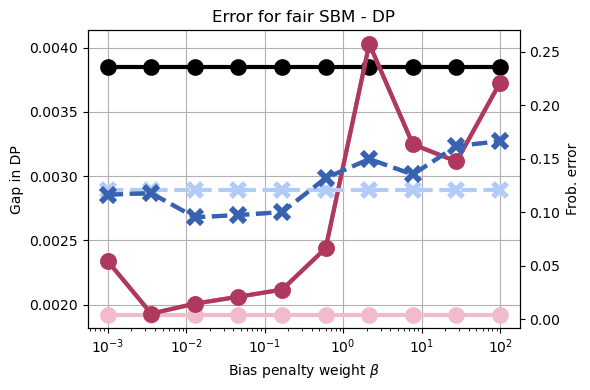

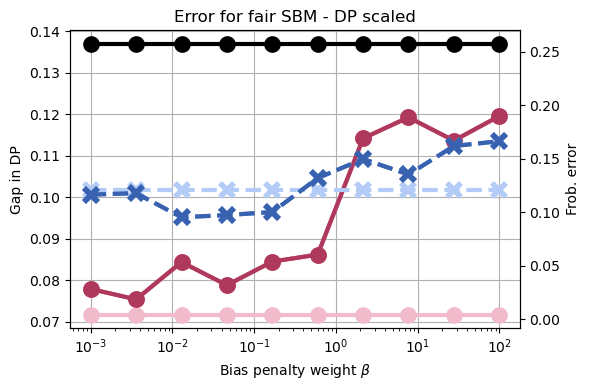

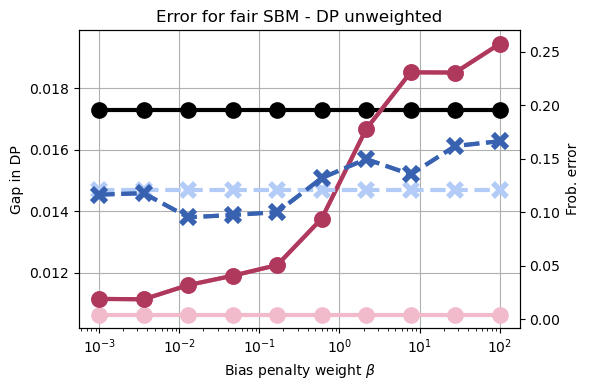

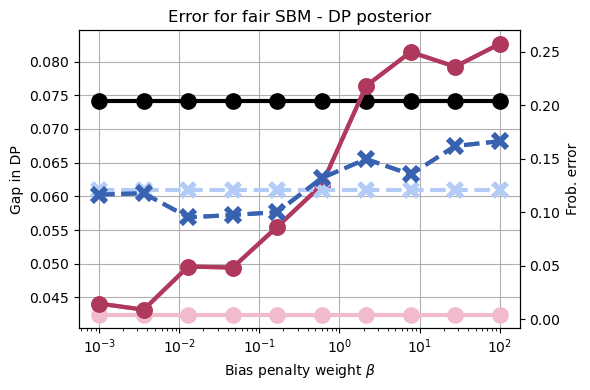

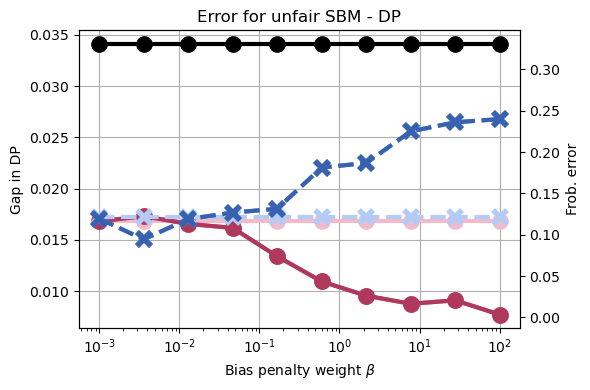

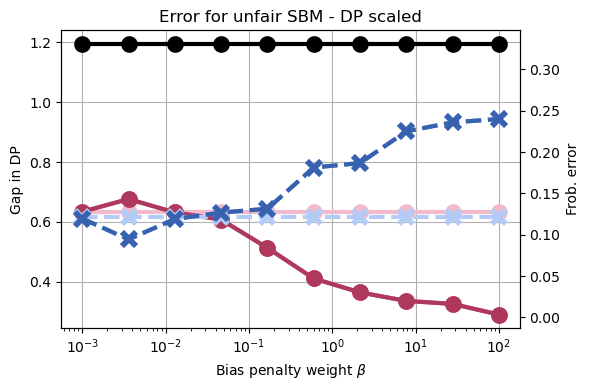

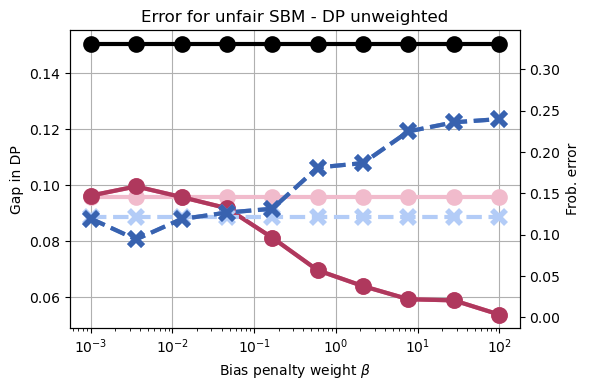

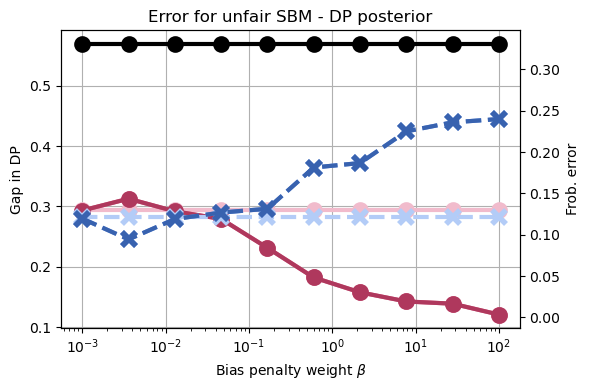

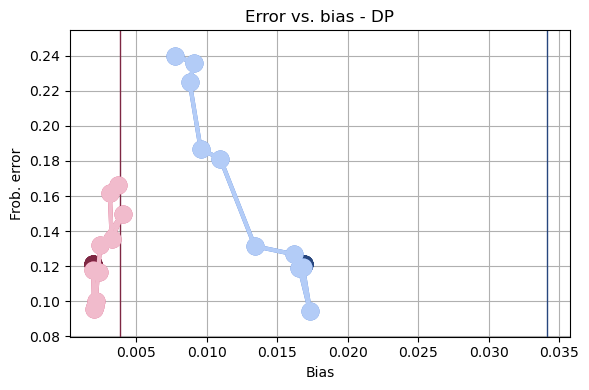

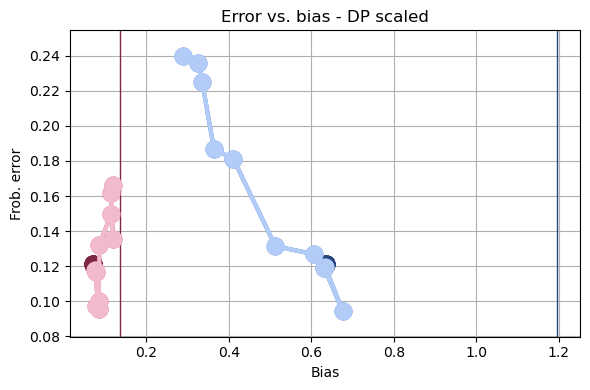

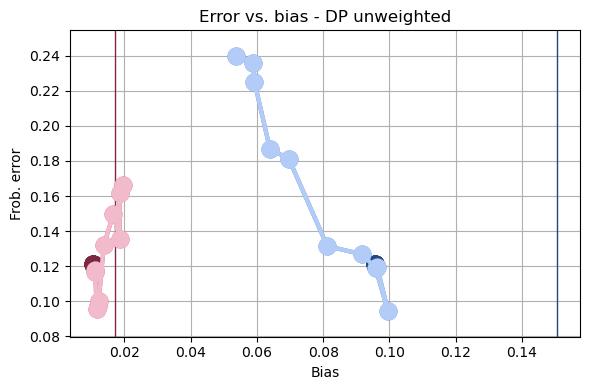

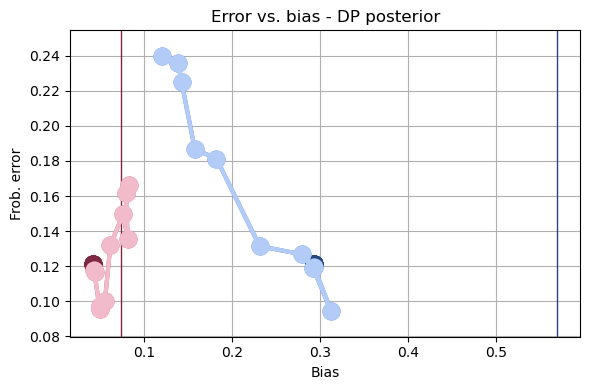

In [18]:
# Fair 2-SBM and biased 2-SBM as fairness penalty grows
from exp_class import *
import networkx as nx
import pandas as pd
# --------------------------------

# --------------------------------
print('Fair 2-SBM and biased 2-SBM as fairness penalty grows')
# --------------------------------


# --------------------------------
config_name = 'config/sbm.jsonc'
exp_params = load_params(config_name)
G = exp_params['G']
N = exp_params['N']
N = N + N%2
num_trials = exp_params['num_trials']
#num_trials = 1
params = {key:exp_params[key] for key in ['beta','lamb','eta','verbose']}
# --------------------------------


# --------------------------------
# Experiment settings
verbose = True
num_range = 10

beta_range = np.linspace(1e-6,1e-4,num_range)
beta_range = np.logspace(-3,2,num_range)
# --------------------------------


# --------------------------------
# Results
results_bias = {key_f: {key_b: { key_m: np.zeros((num_trials,num_range))
                for key_m in ['true','nti','dp','nodewise']}
                for key_b in ['dp','dp_scaled','dp_unweighted','ratio']}
                for key_f in ['fair','unfair']}
results_frob = {key_f: { key_m: np.zeros((num_trials,num_range))
                for key_m in ['true','nti','dp','nodewise']}
                for key_f in ['fair','unfair']}
results_f1 = {key_f: { key_m: np.zeros((num_trials,num_range))
              for key_m in ['true','nti','dp','nodewise']}
              for key_f in ['fair','unfair']}
# --------------------------------


# --------------------------------
m_name = { 'nti':'Van.  ', 'dp':'DP    ', 'nodewise':'Nw. DP' }
tab = '    '
seed = 1111
np.random.seed(seed)
for t in range(num_trials):
    if verbose:
        print('')
        print(f'Trial {t+1} of {num_trials}')
    

    # --------------------------------
    node_labels_sbm = np.ones(N)
    node_labels_sbm[:int(N/2)] = 0
    A = generate_ksbm(N,exp_params['num_blocks'],exp_params['in_prob'],exp_params['out_prob'],block_assign=node_labels_sbm)
    L = np.diag(np.sum(A,axis=0)) - A
    while np.sum( np.linalg.eigh(L)[0] < 1e-9 )>1:
        A = generate_ksbm(N,exp_params['num_blocks'],exp_params['in_prob'],exp_params['out_prob'],block_assign=node_labels_sbm)
        L = np.diag(np.sum(A,axis=0)) - A
    exp = {'unfair':NTIExperiment(A)}
    # C = create_poly_cov(A=exp['unfair'].A,L=exp_params['L'])
    # exp['unfair'].set_C(C)
    exp['unfair'].generate_C(M=exp_params['M'],L=exp_params['L'],signal_model=exp_params['signal_model'])
    exp['fair'] = exp['unfair'].copy_experiment()
    # --------------------------------


    # --------------------------------
    z_unfair = np.ones(N,dtype=int)
    z_unfair[:int(N/2)] = 0
    Z_unfair = np.eye(G)[z_unfair].T
    exp['unfair'].set_Z(Z_unfair)

    z_fair = np.ones(N,dtype=int)
    z_fair[np.arange(0,N,2)] = 0
    Z_fair = np.eye(G)[z_fair].T
    exp['fair'].set_Z(Z_fair)
    # --------------------------------


    # --------------------------------
    for i,beta in enumerate(beta_range):
        if verbose:
            print(f'Beta: {beta:.4e}')
        params['beta'] = beta

        # --------------------------------
        for key_f in ['unfair','fair']:
            print(f'{tab*1}SBM - {key_f}')

            # --------------------------------
            # Estimate graphs and compute error and bias

            # True bias
            key_m = 'true'
            for key_b in ['dp','dp_scaled','dp_unweighted','ratio']:
                results_bias[key_f][key_b][key_m][t,i] = exp[key_f].compute_true_bias(bias_type=key_b)
            
            # Estimated bias and error
            for key_m in ['nti','dp','nodewise']:
                params['bias_type'] = key_m
                exp[key_f].est_A(params,BIAS_PENALTY=params['bias_type']!='nti')
                for key_b in ['dp','dp_scaled','dp_unweighted','ratio']:
                    results_bias[key_f][key_b][key_m][t,i] = exp[key_f].compute_est_bias(bias_type=key_b)
                results_frob[key_f][key_m][t,i] = exp[key_f].compute_frob_error()
                results_f1[key_f][key_m][t,i] = exp[key_f].compute_f1_score()
                if verbose:
                    print(f"{tab*2}{m_name[key_m]} | DP: {results_bias[key_f]['dp'][key_m][t,i]:.3f}, Err.: {results_frob[key_f][key_m][t,i]:.3f}, F1: {results_f1[key_f][key_m][t,i]:.3f}")
            # --------------------------------
        # --------------------------------
    # --------------------------------
# --------------------------------


# --------------------------------
bias_mean = {key_f: {key_b: {key_m: np.mean(results_bias[key_f][key_b][key_m],axis=0)
             for key_m in ['true','nti','dp','nodewise']}
             for key_b in ['dp','dp_scaled','dp_unweighted','ratio']}
             for key_f in ['fair','unfair']}
frob_mean = {key_f: {key_m: np.mean(results_frob[key_f][key_m],axis=0)
             for key_m in ['nti','dp','nodewise']}
             for key_f in ['fair','unfair']}
f1_mean = {key_f: {key_m: np.mean(results_f1[key_f][key_m],axis=0)
           for key_m in ['nti','dp','nodewise']}
           for key_f in ['fair','unfair']}

bias_min = np.min([np.min(bias_mean[key_f][key_b][key_m]) for key_f in bias_mean.keys() for key_b in bias_mean[key_f].keys() for key_m in bias_mean[key_f][key_b].keys()])
bias_max = np.max([np.max(bias_mean[key_f][key_b][key_m]) for key_f in bias_mean.keys() for key_b in bias_mean[key_f].keys() for key_m in bias_mean[key_f][key_b].keys()])
frob_min = np.min([np.min(frob_mean[key_f][key_m]) for key_f in frob_mean.keys() for key_m in frob_mean[key_f].keys()])
frob_max = np.max([np.max(frob_mean[key_f][key_m]) for key_f in frob_mean.keys() for key_m in frob_mean[key_f].keys()])
# --------------------------------


# --------------------------------
biastype_name = {
    'dp':"DP",
    'dp_scaled':"DP scaled",
    'dp_unweighted':"DP unweighted",
    'ratio':"DP posterior",
}
for key_f in ['fair','unfair']:
    # --------------------------------
    for key_b in ['dp','dp_scaled','dp_unweighted','ratio']:
        # --------------------------------
        fig = plt.figure(figsize=(6,4))
        ax1 = fig.subplots()
        ax1.grid(True)
        ax1.set_xlabel('Bias penalty weight '+r'$\beta$')
        ax2 = ax1.twinx()
        ax1.set_ylabel('Gap in DP')
        ax2.set_ylabel('Frob. error')

        ax1.set_title(f"Error for {key_f} SBM - {biastype_name[key_b]}")
        # --------------------------------


        # --------------------------------
        plt_args = {}
        plt_args['marker'] = 'o'
        plt_args['markeredgewidth'] = 2
        plt_args['linestyle'] = '-'
        plt_args['markersize'] = 10
        plt_args['linewidth'] = 3
        # --------------------------------


        # --------------------------------
        for key_m,c_m in dict(zip(['true','nti','dp','nodewise'],['k',reds[2],reds[8],reds[14]])).items():
            #ax1.plot(beta_range, bias_mean[key_f][key_b][key_m], **plt_args, c=c_m)
            ax1.semilogx(beta_range, bias_mean[key_f][key_b][key_m], **plt_args, c=c_m)
        # --------------------------------
        

        # --------------------------------
        plt_args['marker'] = 'x'
        plt_args['markeredgewidth'] = 4
        plt_args['linestyle'] = '--'
        # --------------------------------


        # --------------------------------
        for key_m,c_m in dict(zip(['nti','dp','nodewise'],[blues[2],blues[8],blues[14]])).items():
            #ax2.plot(beta_range, frob_mean[key_f][key_m], **plt_args, c=c_m)
            ax2.semilogx(beta_range, frob_mean[key_f][key_m], **plt_args, c=c_m)
        # --------------------------------


        # --------------------------------
        my_ylim = list(ax2.get_ylim())
        my_ylim = np.maximum((my_ylim[0]-.1),-.02),np.minimum((my_ylim[1]+.1),1.02)
        ax2.set_ylim(my_ylim)
        fig.tight_layout()
        # --------------------------------
    # --------------------------------
# --------------------------------


# --------------------------------
my_ylim = [frob_min - .1*(frob_max-frob_min), frob_max + .1*(frob_max-frob_min)]
biastype_name = {
    'dp':"DP",
    'dp_scaled':"DP scaled",
    'dp_unweighted':"DP unweighted",
    'ratio':"DP posterior",
}
for key_b in ['dp','dp_scaled','dp_unweighted','ratio']:
    # --------------------------------
    fig = plt.figure(figsize=(6,4))
    ax = fig.subplots()
    ax.grid(True)
    ax.set_xlabel('Bias')
    ax.set_ylabel('Frob. error')
    ax.set_title(f"Error vs. bias - {biastype_name[key_b]}")
    # --------------------------------

    # --------------------------------
    for key_f in ['fair','unfair']:
        # --------------------------------
        key_m = 'true'
        line_args = {}
        line_args['linestyle'] = '-'
        line_args['linewidth'] = 1
        line_args['c'] = reds[18] if key_f=='fair' else blues[18]
        ax.plot([bias_mean[key_f][key_b][key_m][0]]*2,my_ylim,**line_args)
        # --------------------------------


        # --------------------------------
        for key_m,c_m in dict(zip(['nti','dp','nodewise'],[18,10,2])).items():
            mkr_args = {}
            mkr_args['marker'] = 'o'
            mkr_args['linestyle'] = ''
            mkr_args['markeredgewidth'] = 3
            mkr_args['markersize'] = 10
            line_args = {}
            line_args['linestyle'] = '-'
            line_args['linewidth'] = 3
            mkr_args['c'] = reds[c_m] if key_f=='fair' else blues[c_m]
            line_args['c'] = reds[c_m] if key_f=='fair' else blues[c_m]
            ax.plot(bias_mean[key_f][key_b][key_m],frob_mean[key_f][key_m],**mkr_args)
            for i in range(1,num_range):
                ax.plot(bias_mean[key_f][key_b][key_m][i-1:i+1],frob_mean[key_f][key_m][i-1:i+1],**line_args)
        # --------------------------------
    # --------------------------------

    # --------------------------------
    ax.set_ylim(my_ylim)
    fig.tight_layout()
    # --------------------------------
# --------------------------------


# --------------------------------
path = os.getcwd()
for key_f in ['fair','unfair']:
    for key_b in ['dp','dp_scaled','dp_unweighted','ratio']:
        results_dict = dict(zip(['Penalty_Weight',
                                'Bias_True','Bias_NTI','Bias_DP','Bias_NW',
                                'Frob_NTI','Frob_DP','Frob_NW'],
                                [beta_range,
                                bias_mean[key_f][key_b]['true'], bias_mean[key_f][key_b]['nti'], bias_mean[key_f][key_b]['dp'], bias_mean[key_f][key_b]['nodewise'],
                                frob_mean[key_f]['nti'], frob_mean[key_f]['dp'], frob_mean[key_f]['nodewise'] ]))
        pd.DataFrame(results_dict).to_csv(path + f'/sbm_{key_f}_{key_b}.csv', index=False)
# --------------------------------